# Distributional Counterfactual Explanation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

from models.mlp import BlackBoxModel

pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

## Read and Process Data

In [2]:
df_ = pd.read_csv('data/hotel_booking/hotel_bookings.csv')
df = df_.copy()
target_name = 'is_canceled'
target = df[target_name]

In [3]:
# Initialize a label encoder
label_encoder = LabelEncoder()
label_mappings = {}


# Convert categorical columns to numerical representations using label encoding
for column in df.columns:
    if df[column].dtype == 'object':
        # Handle missing values by filling with a placeholder and then encoding
        df[column] = df[column].fillna('Unknown')
        df[column] = label_encoder.fit_transform(df[column])
        label_mappings[column] = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))


# For columns with NaN values that are numerical, we will impute them with the median of the column
for column in df.columns:
    if df[column].isna().any():
        median_val = df[column].median()
        df[column].fillna(median_val, inplace=True)

# Display the first few rows of the transformed dataframe
df.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,0,342,2015,5,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,3,0,14.0,179.0,0,2,0.0,0,0,1,121
1,1,0,737,2015,5,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,4,0,14.0,179.0,0,2,0.0,0,0,1,121
2,1,0,7,2015,5,27,1,0,1,1,0.0,0,0,59,3,1,0,0,0,0,2,0,0,14.0,179.0,0,2,75.0,0,0,1,122
3,1,0,13,2015,5,27,1,0,1,1,0.0,0,0,59,2,0,0,0,0,0,0,0,0,304.0,179.0,0,2,75.0,0,0,1,122
4,1,0,14,2015,5,27,1,0,2,2,0.0,0,0,59,6,3,0,0,0,0,0,0,0,240.0,179.0,0,2,98.0,0,1,1,123


## Model Training

In [4]:
features = [
    # 'hotel', 
    'lead_time', 
    # 'arrival_date_year', 
    # 'arrival_date_month',
    # 'arrival_date_week_number', 
    # 'arrival_date_day_of_month',
    # 'stays_in_weekend_nights', 
    # 'stays_in_week_nights', 
    # 'adults', 
    # 'children',
    # 'babies', 
    # 'meal', 
    # 'country', 
    # 'market_segment', 
    # 'distribution_channel',
    # 'is_repeated_guest', 
    # 'previous_cancellations',
    # 'previous_bookings_not_canceled', 
    # 'reserved_room_type',
    # 'assigned_room_type', 
    'booking_changes', 
    # 'deposit_type', 
    # 'agent',
    # 'company', 
    # 'days_in_waiting_list', 
    # 'customer_type', 
    # 'adr',
    # 'required_car_parking_spaces', 
    # 'total_of_special_requests'
]

df_X = df[features].copy()
df_y = target

In [5]:
seed = 42

np.random.seed(seed)  # for reproducibility


# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=seed)

std = X_train.std()
mean = X_train.mean()

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

# Initialize the model, loss function, and optimizer
model = BlackBoxModel(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

    # Convert outputs to binary using 0.5 as threshold
    y_pred_tensor = (test_outputs > 0.5).float()
    correct_predictions = (y_pred_tensor == y_test_tensor).float().sum()
    accuracy = correct_predictions / y_test_tensor.shape[0]

accuracy.item()

0.6767317056655884

## Counterfactual Explanation

In [9]:
sample_num = 5

indice = (X_test.sample(sample_num)).index

In [10]:
X = X_test.loc[indice].values
y = model(torch.FloatTensor(X))

y_target = torch.zeros_like(y)

y_true = y_test.loc[indice]

In [11]:
from explainers.dce import DistributionalCounterfactualExplainer

explainer = DistributionalCounterfactualExplainer(model=model, X=X, y_target=y_target, lr=1e-1, epsilon=0.5, lambda_val=100)

In [12]:
explainer.optimize(max_iter=100)

Iter 1: Q = 48.203468322753906, term1 = 0.008975362405180931, term2 = 48.19449234008789
Iter 2: Q = 48.66570281982422, term1 = 0.01843123883008957, term2 = 48.64727020263672
Iter 3: Q = 48.01287078857422, term1 = 0.04070388898253441, term2 = 47.97216796875
Iter 4: Q = 47.55559158325195, term1 = 0.07407963275909424, term2 = 47.481510162353516
Iter 5: Q = 48.209449768066406, term1 = 0.1167193129658699, term2 = 48.09273147583008
Iter 6: Q = 47.95974349975586, term1 = 0.16883306205272675, term2 = 47.79090881347656
Iter 7: Q = 47.72983169555664, term1 = 0.2282680869102478, term2 = 47.501564025878906
Iter 8: Q = 47.59894561767578, term1 = 0.29498955607414246, term2 = 47.303955078125
Iter 9: Q = 47.52894592285156, term1 = 0.3622102439403534, term2 = 47.1667366027832
Iter 10: Q = 47.46255111694336, term1 = 0.4301653802394867, term2 = 47.032386779785156
Iter 11: Q = 47.42496109008789, term1 = 0.49845337867736816, term2 = 46.92650604248047
Iter 12: Q = 47.40245819091797, term1 = 0.56991899013519

In [13]:
factual_X = df[df_X.columns].loc[indice].copy()
counterfactual_X = pd.DataFrame(explainer.best_X.detach().numpy() * std[df_X.columns].values + mean[df_X.columns].values, columns=df_X.columns)
# counterfactual_X = pd.DataFrame(explainer.best_X.detach().numpy(), columns=df_X.columns)

factual_y = pd.DataFrame(y.detach().numpy(),columns=[target_name], index=factual_X.index)
counterfactual_y = pd.DataFrame(explainer.best_y.detach().numpy(),columns=[target_name], index=factual_X.index)

In [14]:
pd.DataFrame({
    'factual_y': factual_y[target_name].values,
    'counterfactual_y': counterfactual_y[target_name].values,
})

,factual_y,counterfactual_y
0,0.236031,0.271918
1,0.155948,0.001644
2,0.185735,0.913353
3,0.241659,0.001799
4,0.328778,0.915776


In [15]:
factual_y

,is_canceled
94640,0.236031
99873,0.155948
91063,0.185735
22392,0.241659
63729,0.328778


In [22]:
counterfactual_X.index = factual_X.index
counterfactual_X[target_name] = counterfactual_y

In [23]:
factual_X[target_name] = factual_y

In [286]:
counterfactual_X

,lead_time,booking_changes
0,506.120242,-1.694586
1,-174.246724,1.100011
2,713.867972,3.021115
3,381.286518,-2.035264
4,-137.886748,2.151411
...,...,...
95,-199.880180,1.331042
96,372.129090,-1.999916
97,371.770547,-1.205776
98,-145.457785,0.914846


In [279]:
check_column = 'booking_changes'
pd.DataFrame({
    'factual': factual_X[check_column].values, 
    'counterfactual': counterfactual_X[check_column].values
    })

,factual,counterfactual
0,0,-1.694586
1,0,1.100011
2,1,3.021115
3,0,-2.035264
4,1,2.151411
...,...,...
95,0,1.331042
96,0,-1.999916
97,0,-1.205776
98,0,0.914846


In [280]:
factual_X[check_column].mean()

0.09

In [281]:
counterfactual_X[check_column].mean()

-0.2725544166558481

In [284]:
explainer.model(torch.from_numpy(X).float())

tensor([[0.5329],
        [0.2105],
        [0.2259],
        [0.4383],
        [0.2374],
        [0.3728],
        [0.1999],
        [0.2764],
        [0.1703],
        [0.6446],
        [0.4999],
        [0.7015],
        [0.4721],
        [0.4401],
        [0.4599],
        [0.6310],
        [0.4903],
        [0.6966],
        [0.6446],
        [0.4529],
        [0.4333],
        [0.1999],
        [0.2411],
        [0.1947],
        [0.4692],
        [0.4465],
        [0.2051],
        [0.7634],
        [0.3235],
        [0.6917],
        [0.2273],
        [0.2273],
        [0.1658],
        [0.1947],
        [0.2409],
        [0.6446],
        [0.1569],
        [0.5019],
        [0.4424],
        [0.6693],
        [0.1613],
        [0.4675],
        [0.4944],
        [0.7318],
        [0.4179],
        [0.6561],
        [0.3728],
        [0.4476],
        [0.1569],
        [0.9102],
        [0.4459],
        [0.2216],
        [0.3235],
        [0.1846],
        [0.1035],
        [0

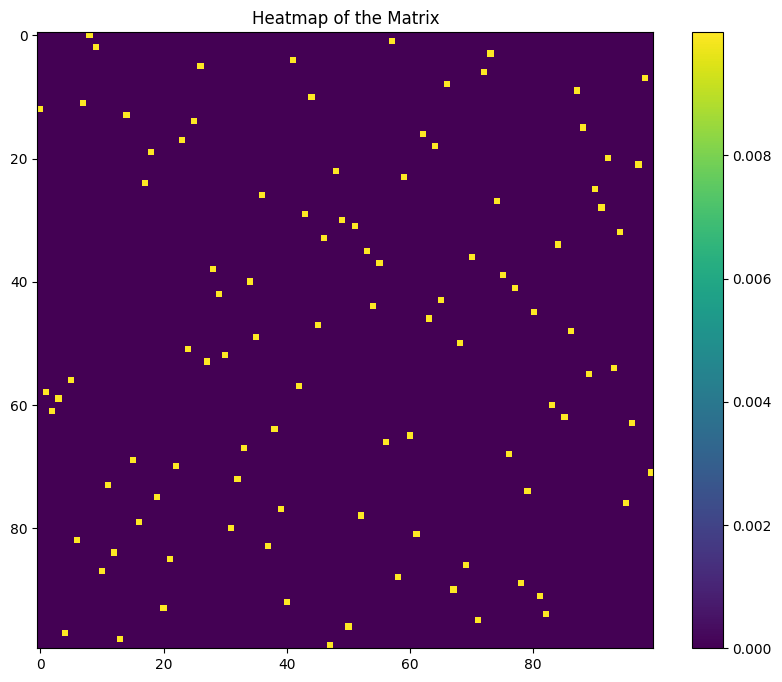

In [278]:
import numpy as np
import matplotlib.pyplot as plt

# Sample matrix for demonstration
matrix = explainer.wd.nu.numpy()

plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.title("Heatmap of the Matrix")
plt.show()
